# Refinements - Improved MNIST Classifer

Make Your First GAN With PyTorch, 2020

In [1]:
# mount Drive to access data files

# from google.colab import drive
# drive.mount('./mount')

In [2]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: NVIDIA GeForce RTX 2060 SUPER


device(type='cuda')

## DataSet Class

In [4]:
# dataset class

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass


## Load Data

In [5]:
#mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

#excute at local -by ysc 2021-12-13
mnist_dataset = MnistDataset('mnist_data/mnist_train.csv')

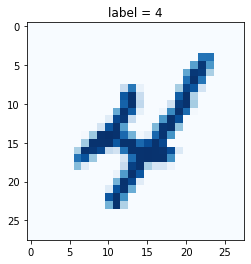

In [6]:
# check data contains images

mnist_dataset.plot_image(9)

In [7]:
# check Dataset class can be accessed by index, returns label, image values and target tensor

mnist_dataset[100]

(5,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

## Neural Network Class

In [8]:
# classifier class

class Classifier(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            #nn.Sigmoid(),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),
            
            nn.Linear(200, 10),
            nn.Sigmoid()
            #nn.LeakyReLU(0.02)
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()
        #self.loss_function = nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        #self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters())

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## Train Neural Network

In [9]:
%%time 
# create neural network

C = Classifier()
C = C.to(device) #cuda

# train network on MNIST data set

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        image_data_tensor = image_data_tensor.to(device)  #cuda
        target_tensor = target_tensor.to(device)          #cuda
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 59s, sys: 2.39 s, total: 4min 2s
Wall time: 4min 2s


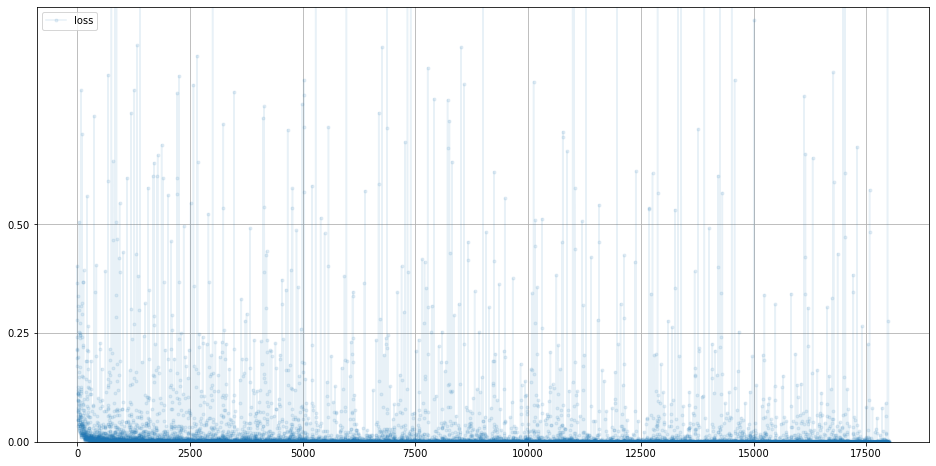

In [10]:
# plot classifier error

C.plot_progress()

## Classification Example

In [11]:
# load MNIST test data

# mnist_test_dataset = MnistDataset('mount/My Drive/Colab Notebooks/gan/mnist_data/mnist_test.csv')


#excute at local -by ysc 2021-12-13
mnist_test_dataset = MnistDataset('mnist_data/mnist_test.csv')

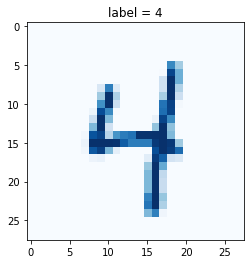

In [12]:
# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

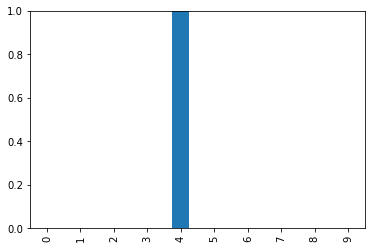

In [13]:
# visualise the answer given by the neural network

image_data = mnist_test_dataset[record][1]

# query from trained network
image_data = image_data.to(device) #cuda
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.cpu().detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1)) #cuda

## Classifier Performance

In [14]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    image_data_tensor = image_data_tensor.to(device)  #cuda
    answer = C.forward(image_data_tensor).cpu().detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9747 10000 0.9747


## Save and Load

In [15]:
torch.save(C, "./model")

In [16]:
!ls -lh model

-rw-rw-r-- 1 ysc ysc 2.0M Dec 14 00:09 model


In [17]:
model_load=torch.load("./model")

model_load

Classifier(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): Sigmoid()
  )
  (loss_function): BCELoss()
)

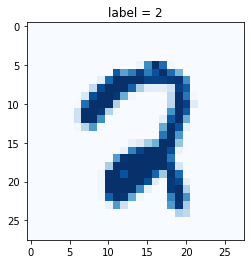

In [18]:
# pick a record
record = 119

# plot image and correct label
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

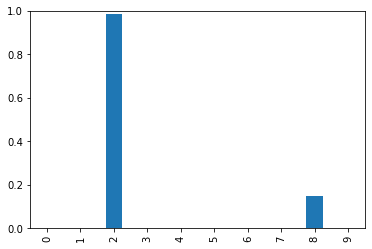

In [19]:
# visualise the answer given by the neural network

image_data = mnist_test_dataset[record][1]

# query from trained network
image_data = image_data.to(device) #cuda

## Use Loaded model
output = model_load.forward(image_data)  

# plot output tensor
pandas.DataFrame(output.cpu().detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1)) #cuda